In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule
import src.models.heuristics.fcfs as fcfs


# Simulation
from src.simulation.ProductionDaySimulation import ProductionDaySimulation


# Extern
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [2]:
max_time = 60 * 30 # 30 min

## Laden der Produktionsaufträge

In [3]:
data_path = get_path("data", "cp_lateness")
file_template = "02_{text}.csv"

In [4]:
file = file_template.format(text= "all_job_times")

df_job_times_all = pd.read_csv(data_path / file)
df_job_times_all['Job'] = df_job_times_all['Job'].astype(str)
df_job_times_all

,Job,Production_Plan_ID,Arrival,Deadline,Ready Time,Processing Time,Slack
0,0,0,49,2027,1440,395,192
1,1,1,130,2683,1440,510,733
2,2,2,151,2994,1440,568,986
3,3,3,226,3505,1440,655,1410
4,4,4,386,2353,1440,393,520
...,...,...,...,...,...,...,...
415,415,6,28598,30681,28800,416,1465
416,416,4,28606,30573,28800,393,1380
417,417,5,28722,31205,28800,496,1909
418,418,7,28746,31444,28800,539,2105


In [5]:
file = file_template.format(text= "all_jssp")
df_jssp_all = pd.read_csv(data_path / file)
df_jssp_all['Job'] = df_jssp_all['Job'].astype(str)
df_jssp_all

,Job,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,0,M00,29
1,0,0,1,M01,78
2,0,0,2,M02,9
3,0,0,3,M03,36
4,0,0,4,M04,49
...,...,...,...,...,...
4195,419,8,5,M09,11
4196,419,8,6,M06,40
4197,419,8,7,M07,89
4198,419,8,8,M04,26


## Laden der Initialisierungsdaten vom Tag 1

In [6]:
day_numb = 1

In [7]:
file = file_template.format(text= f"schedule_{day_numb:02d}_init")
df_schedule = pd.read_csv(data_path / file)
df_schedule 

,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,1,1,0,M00,136,2401,1440,43,1483,-918,0,918
1,3,3,0,M01,236,1873,1440,81,1521,-352,0,352
2,15,7,0,M02,1193,3082,1440,31,1471,-1611,0,1611
3,4,4,0,M02,404,3093,1471,14,1485,-1608,0,1608
4,12,8,0,M00,992,2717,1483,76,1559,-1158,0,1158
...,...,...,...,...,...,...,...,...,...,...,...,...
175,17,3,8,M09,1343,3576,3374,22,3396,-180,0,180
176,16,1,9,M08,1310,3414,3384,30,3414,0,0,0
177,17,3,9,M05,1343,3576,3533,43,3576,0,0,0
178,14,4,9,M06,1177,4133,4080,53,4133,0,0,0


In [8]:
# bereits Ausgeführte Operationen
file = file_template.format(text= f"execution_{day_numb:02d}")
df_execution = pd.read_csv(data_path / file)
df_execution

,Job,Production_Plan_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,0,0,0,M00,51,2108.37,35.14,2143.51
1,0,0,1,M01,51,2265.71,48.26,2313.97
2,0,0,2,M02,51,2359.71,11.08,2370.79
3,0,0,3,M03,51,2516.52,28.98,2545.50
4,0,0,4,M04,51,2840.34,46.13,2886.47
...,...,...,...,...,...,...,...,...
137,16,1,1,M02,1310,2240.68,110.75,2351.43
138,16,1,2,M04,1310,2774.49,65.85,2840.34
139,17,3,0,M01,1343,2313.97,70.77,2384.74
140,17,3,1,M02,1343,2522.55,85.40,2607.95


In [9]:
# für die Vergangenheit geplante Operationen, die nicht geschaft abgearbeitet wurden 
file = file_template.format(text= f"plan_{day_numb:02d}_undone")
df_undone = pd.read_csv(data_path / file)
df_undone

,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,0,0,5,M05,51,3302,2820,11,2831,-471,0,471
1,8,8,8,M04,550,3151,2820,26,2846,-305,0,305
2,0,0,6,M06,51,3302,2831,62,2893,-409,0,409
3,16,1,3,M09,1310,3414,2831,11,2842,-572,0,572
4,16,1,4,M03,1310,3414,2842,69,2911,-503,0,503
...,...,...,...,...,...,...,...,...,...,...,...,...
33,17,3,8,M09,1343,3576,3374,22,3396,-180,0,180
34,16,1,9,M08,1310,3414,3384,30,3414,0,0,0
35,17,3,9,M05,1343,3576,3533,43,3576,0,0,0
36,14,4,9,M06,1177,4133,4080,53,4133,0,0,0


## Rolling Planning ab Tag 2

In [10]:
file_template = "03_simple_{text}.csv"

In [11]:
first_start = 2
last_planning_start = 8

day_length = 1440

Day 02: [2880, 4320)
[INFO] Anzahl Jobs mit Ready Time 2880: 21
[INFO] 38 zusätzliche Operationen hinzugefügt (gesamt: 248).
[INFO] 2 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 9464.00
Best Objective Bound  : 9448.00
Laufzeit              : 0.56 Sekunden


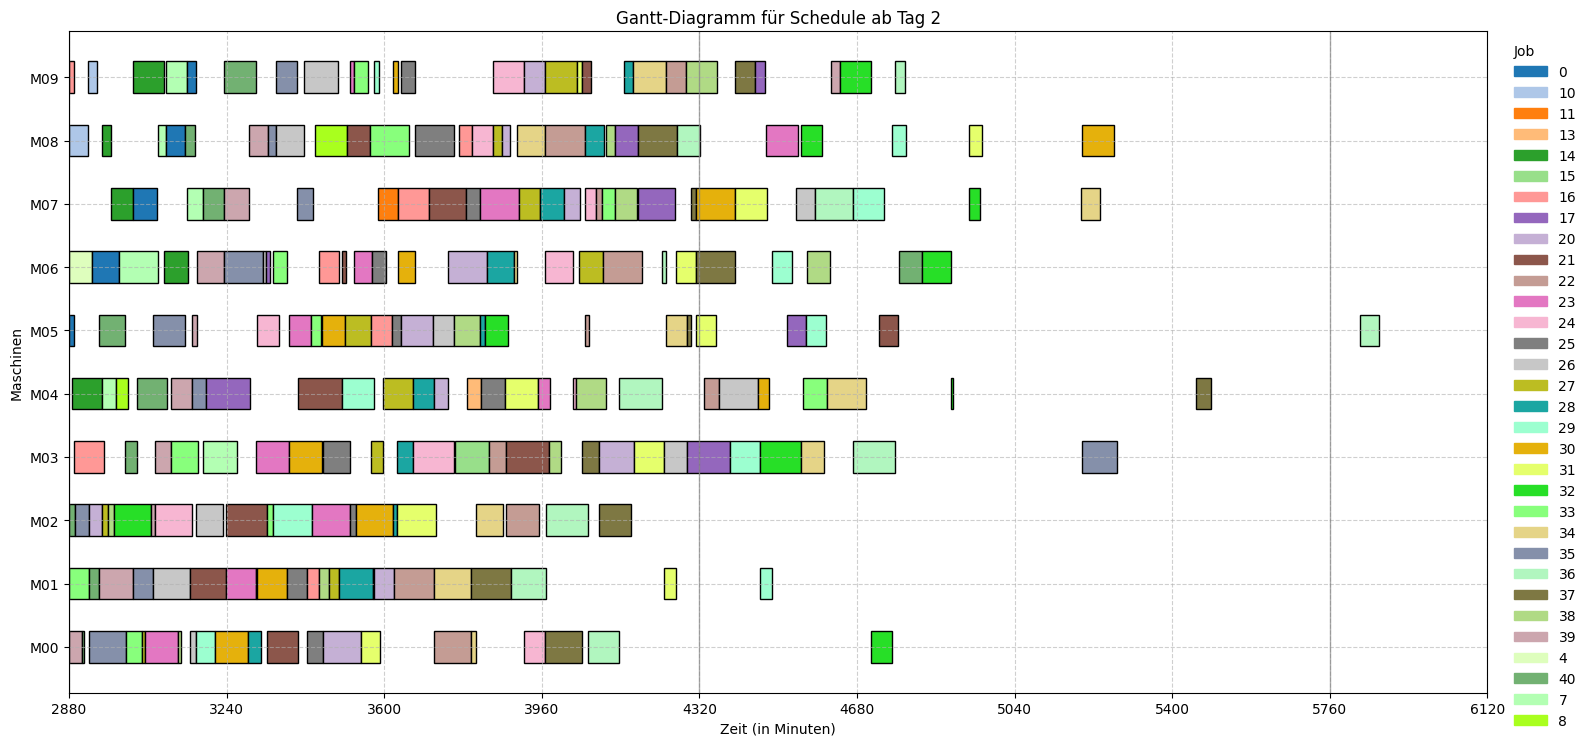

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              25
0 - 60          2
60 - 120        1
120 - 180       0
180 - 240       0
>240            2
Name: count, dtype: int64
[48:00:00] Job 0 started on M05
[48:00:00] Job 10 started on M08
[48:00:00] Job 16 started on M09
[48:00:00] Job 33 started on M01
[48:00:00] Job 39 started on M00
[48:00:00] Job 4 started on M06
[48:00:00] Job 40 started on M02
[48:07:00] Job 14 started on M04
[48:07:16] Job 0 finished on M05 (after 07 minutes 16 seconds)
[48:12:11] Job 16 finished on M09 (after 12 minutes 11 seconds)
[48:12:11] Job 16 started on M03
[48:12:13] Job 40 finished on M02 (after 12 minutes 14 seconds)
[48:14:00] Job 35 started on M0

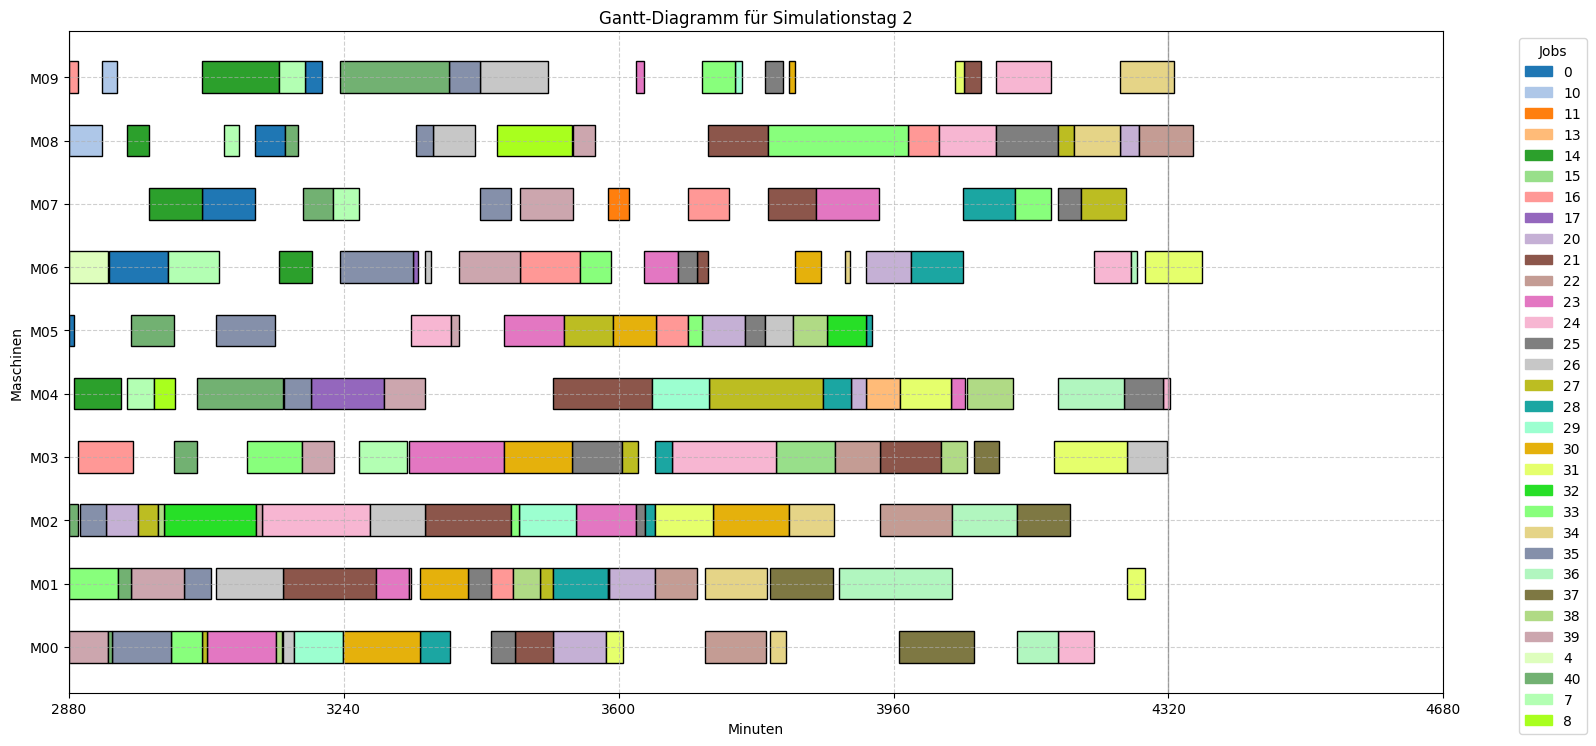

----------------------------------------------------------------------
Day 03: [4320, 5760)
[INFO] Anzahl Jobs mit Ready Time 4320: 17
[INFO] 64 zusätzliche Operationen hinzugefügt (gesamt: 234).
[INFO] 4 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 8441.00
Best Objective Bound  : 8441.00
Laufzeit              : 3.03 Sekunden


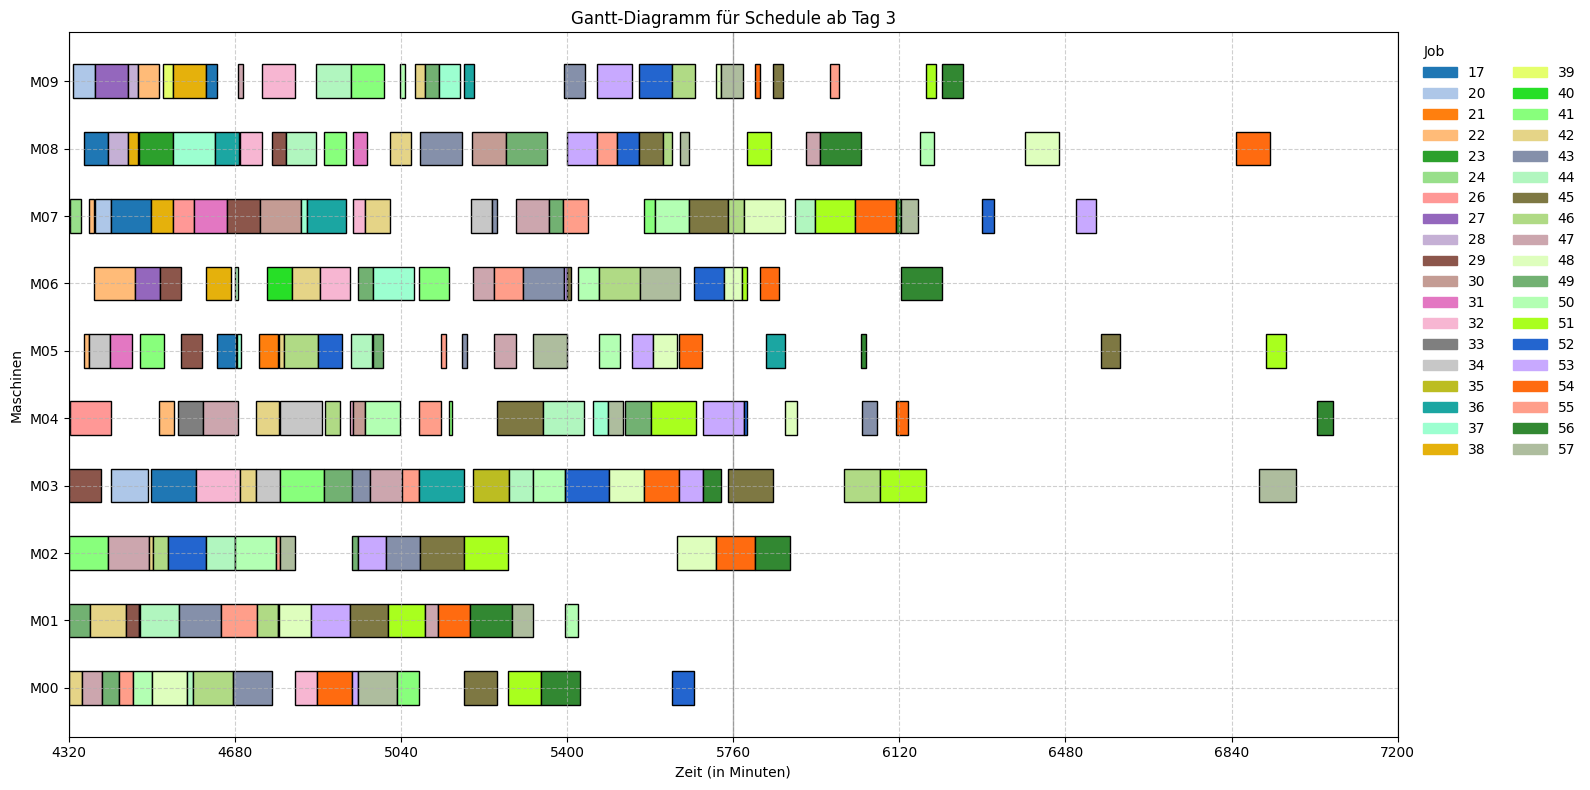

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      1
-60 - 0         1
0              28
0 - 60          2
60 - 120        1
120 - 180       0
180 - 240       1
>240            4
Name: count, dtype: int64
[72:00:00] Job 29 started on M03
[72:00:00] Job 41 started on M02
[72:00:00] Job 42 started on M00
[72:00:00] Job 49 started on M01
[72:02:00] Job 24 started on M07
[72:02:00] Job 26 started on M04
[72:08:00] Job 20 started on M09
[72:22:49] Job 24 finished on M07 (after 20 minutes 50 seconds)
[72:30:14] Job 42 finished on M00 (after 30 minutes 14 seconds)
[72:30:14] Job 47 started on M00
[72:33:00] Job 17 started on M08
[72:33:00] Job 22 started on M05
[72:44:05] Job 22 finished on M05 (after 11 minutes 05 seco

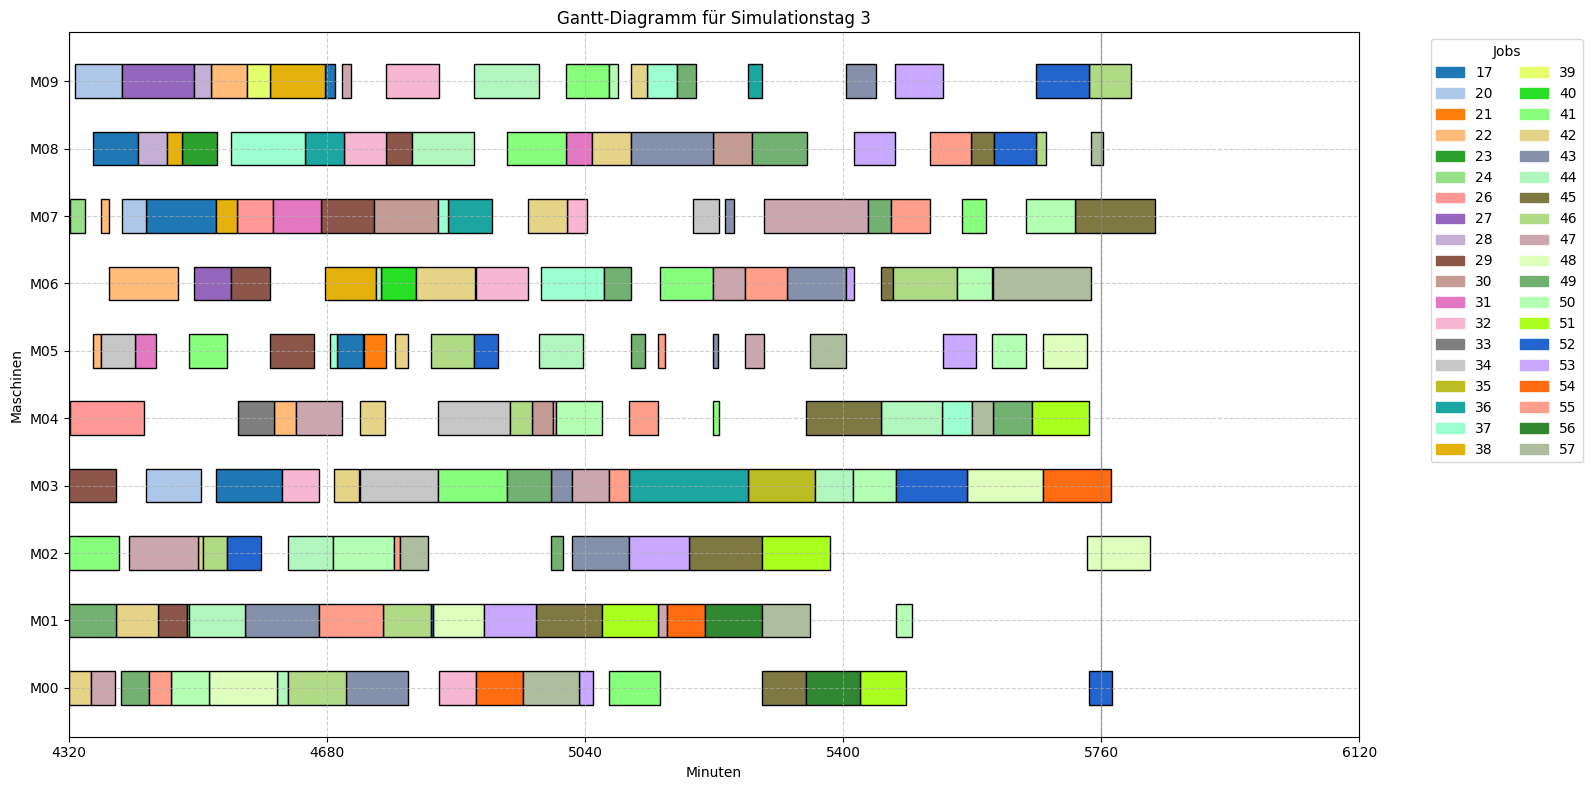

----------------------------------------------------------------------
Day 04: [5760, 7200)
[INFO] Anzahl Jobs mit Ready Time 5760: 17
[INFO] 46 zusätzliche Operationen hinzugefügt (gesamt: 216).
[INFO] 6 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 0.14 Sekunden


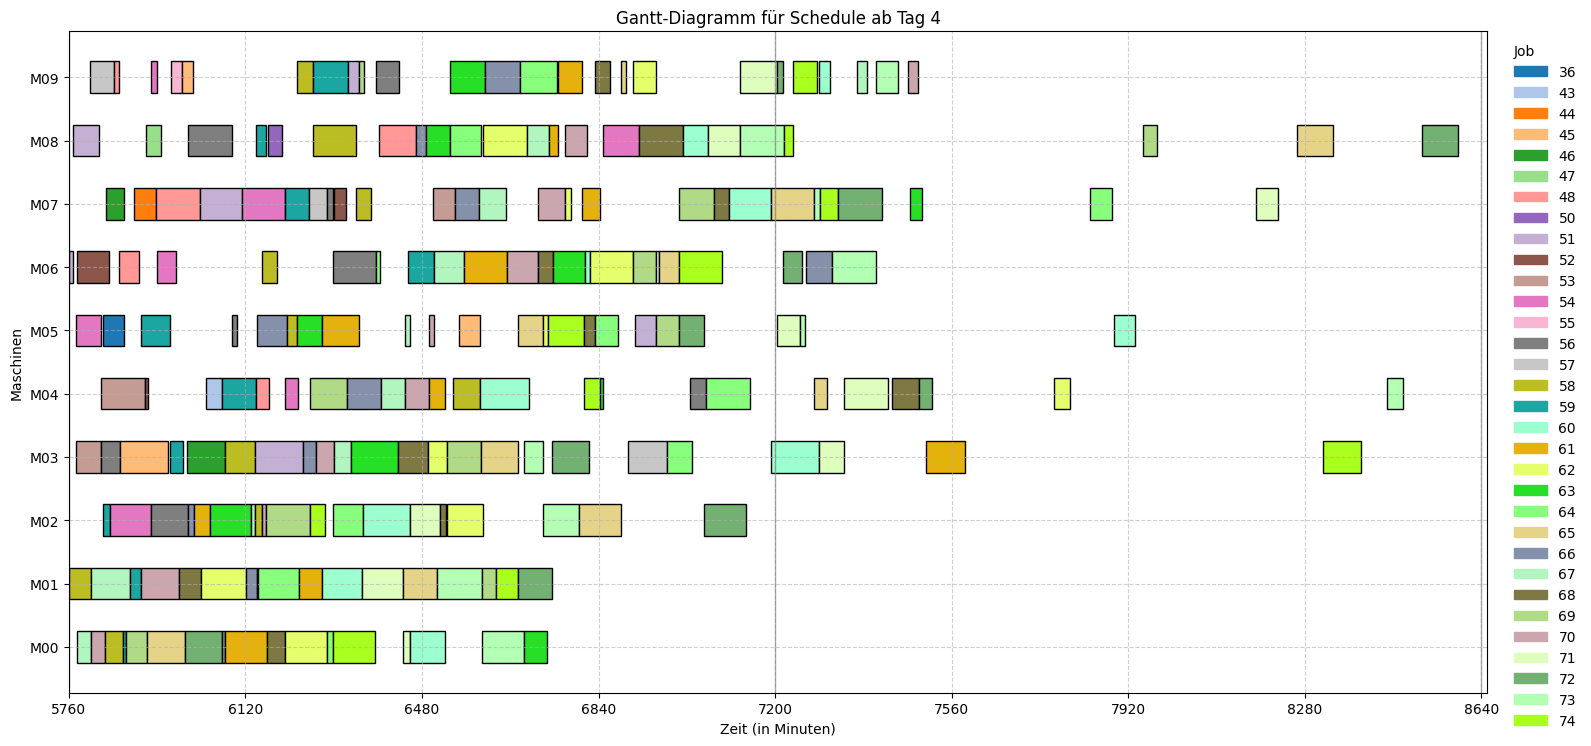

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              32
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
[96:00:00] Job 51 started on M06
[96:00:00] Job 58 started on M01
[96:08:52] Job 51 finished on M06 (after 08 minutes 53 seconds)
[96:09:00] Job 51 started on M08
[96:14:00] Job 53 started on M03
[96:14:00] Job 54 started on M05
[96:16:00] Job 52 started on M06
[96:16:00] Job 67 started on M00
[96:43:00] Job 57 started on M09
[96:45:11] Job 58 finished on M01 (after 45 minutes 11 seconds)
[96:49:35] Job 67 finished on M00 (after 33 minutes 35 seconds)
[96:49:35] Job 70 started on M00
[96:49:35] Job 67 started on

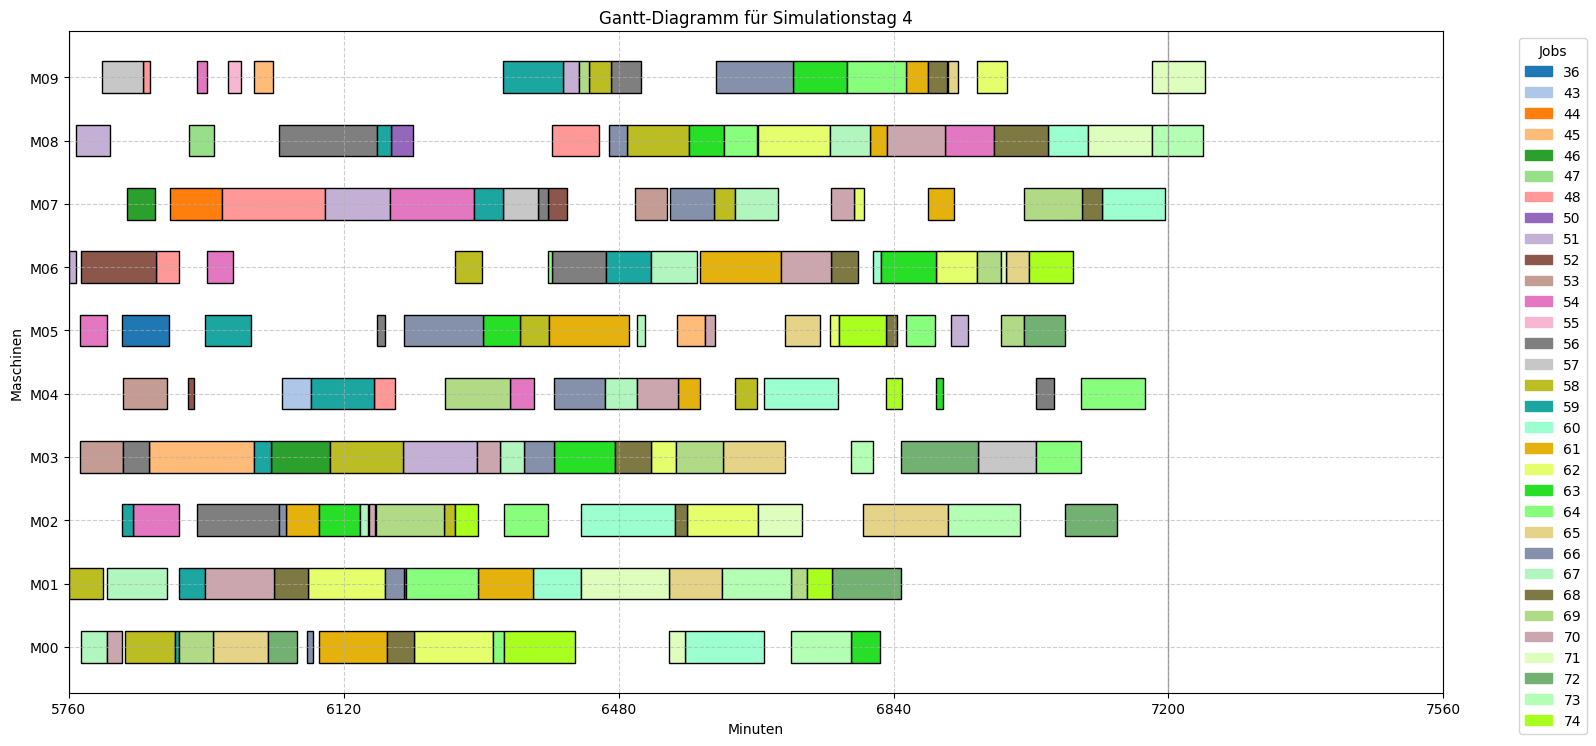

----------------------------------------------------------------------
Day 05: [7200, 8640)
[INFO] Anzahl Jobs mit Ready Time 7200: 21
[INFO] 33 zusätzliche Operationen hinzugefügt (gesamt: 243).
[INFO] 2 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 0.17 Sekunden


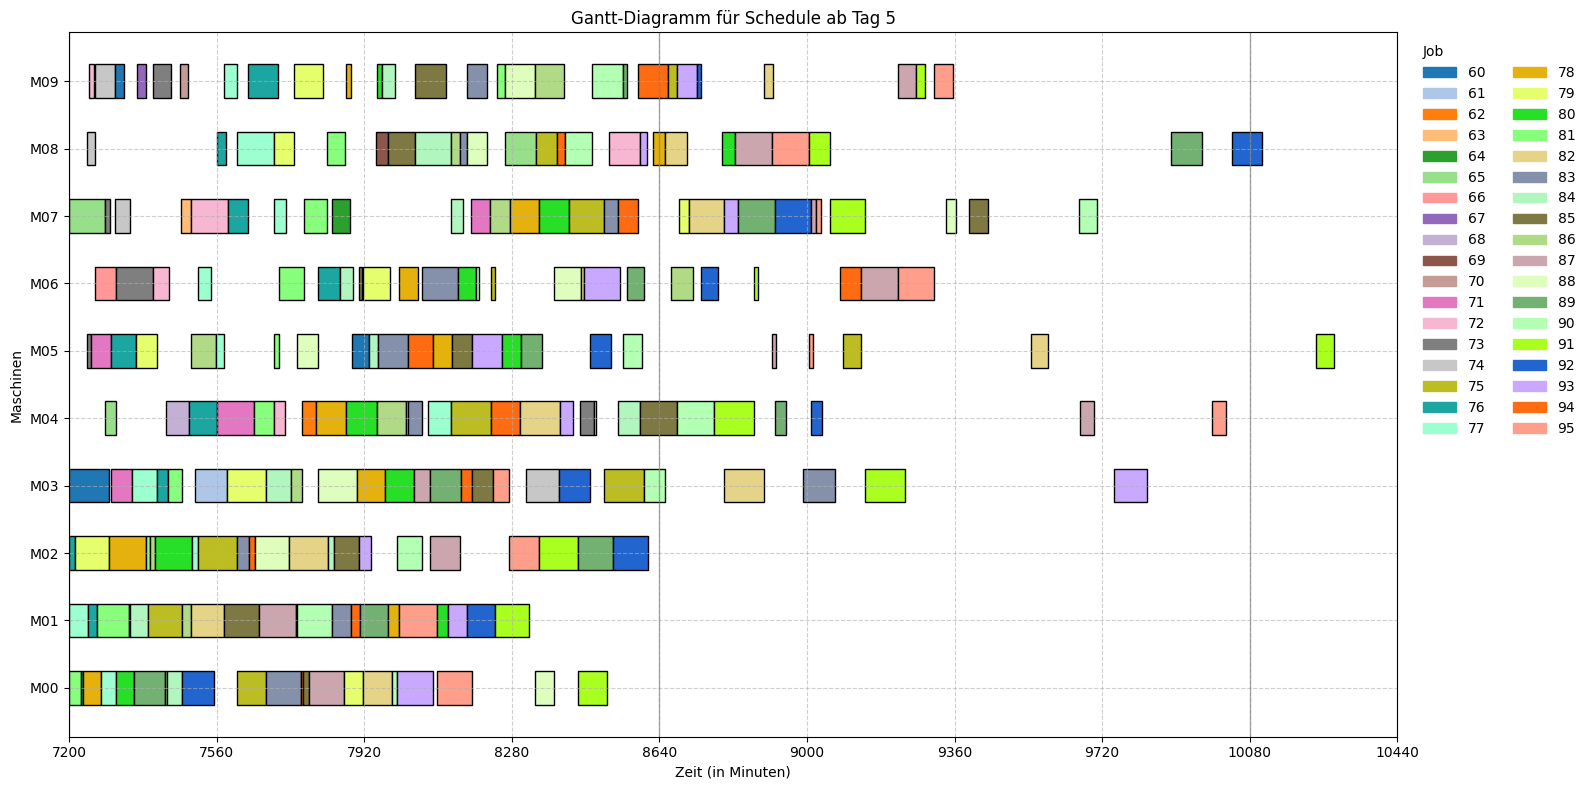

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              36
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
[120:00:00] Job 60 started on M03
[120:00:00] Job 65 started on M07
[120:00:00] Job 76 started on M02
[120:00:00] Job 77 started on M01
[120:00:00] Job 81 started on M00
[120:09:32] Job 76 finished on M02 (after 09 minutes 32 seconds)
[120:14:00] Job 79 started on M02
[120:33:11] Job 81 finished on M00 (after 33 minutes 11 seconds)
[120:33:11] Job 76 started on M00
[120:36:13] Job 77 finished on M01 (after 36 minutes 14 seconds)
[120:37:58] Job 76 finished on M00 (after 04 minutes 47 seconds)
[120:37:58] Job 78 

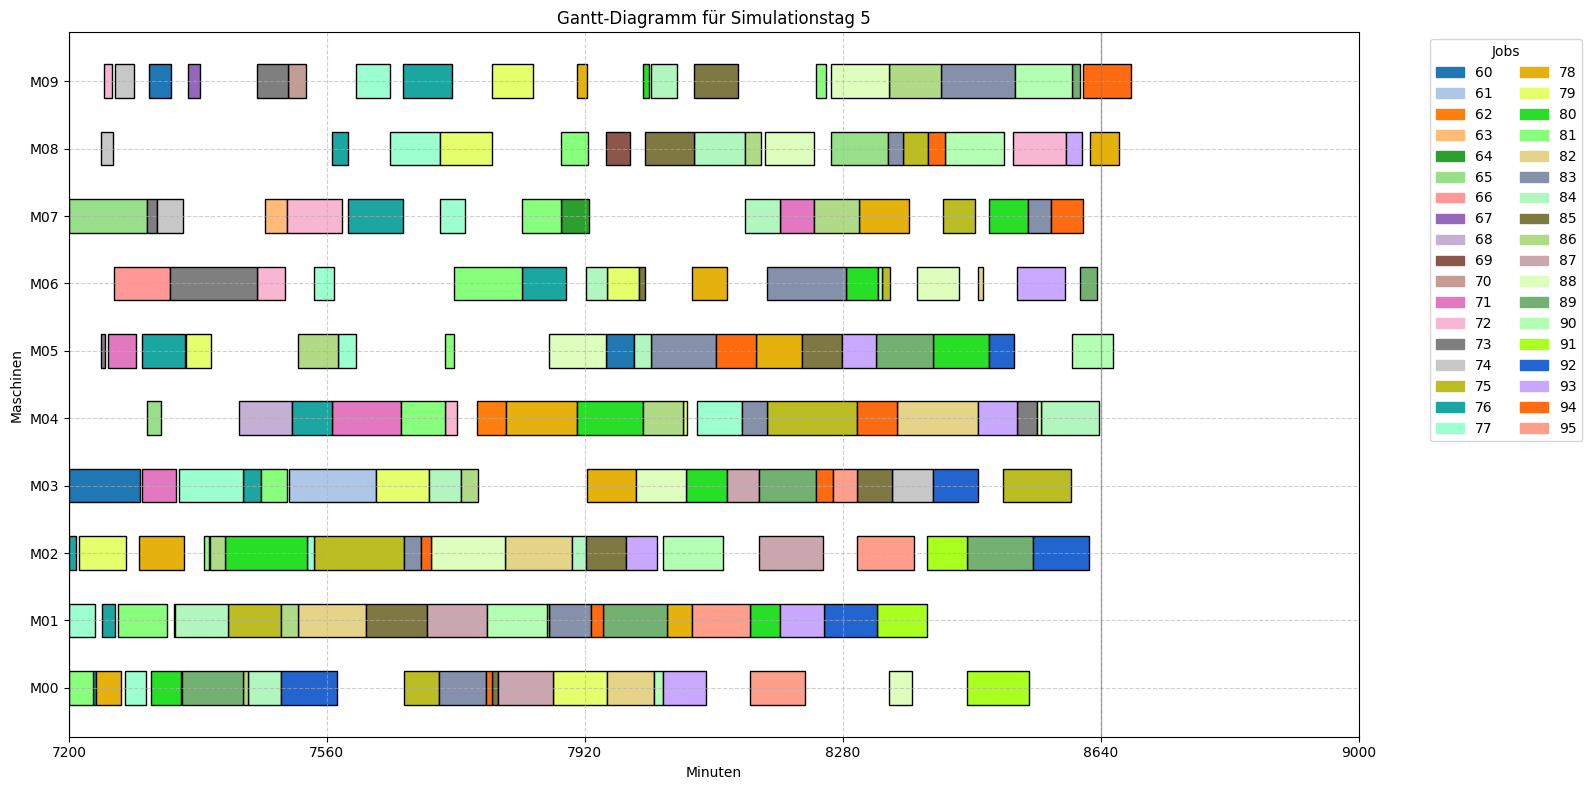

----------------------------------------------------------------------
Day 06: [8640, 10080)
[INFO] Anzahl Jobs mit Ready Time 8640: 29
[INFO] 48 zusätzliche Operationen hinzugefügt (gesamt: 338).
[INFO] 3 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 87.00
Best Objective Bound  : 87.00
Laufzeit              : 5.50 Sekunden


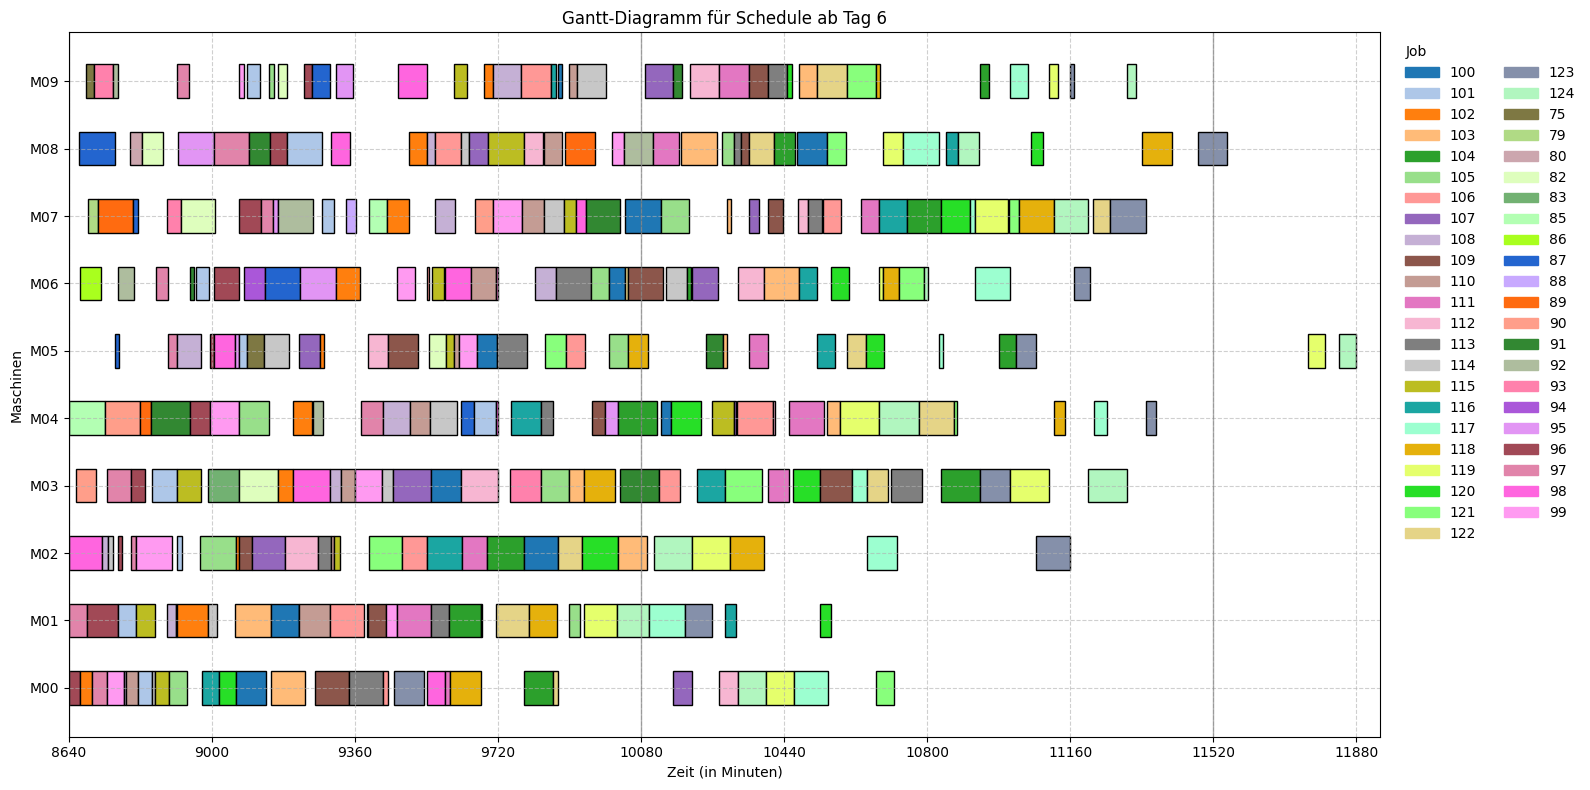

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              43
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
[144:00:00] Job 85 started on M04
[144:00:00] Job 96 started on M00
[144:00:00] Job 97 started on M01
[144:00:00] Job 98 started on M02
[144:17:00] Job 90 started on M03
[144:26:00] Job 87 started on M08
[144:29:00] Job 86 started on M06
[144:36:51] Job 97 finished on M01 (after 36 minutes 51 seconds)
[144:36:54] Job 96 finished on M00 (after 36 minutes 55 seconds)
[144:36:54] Job 102 started on M00
[144:42:00] Job 75 started on M09
[144:46:00] Job 96 started on M01
[144:47:00] Job 79 started on M07
[145:00:15] 

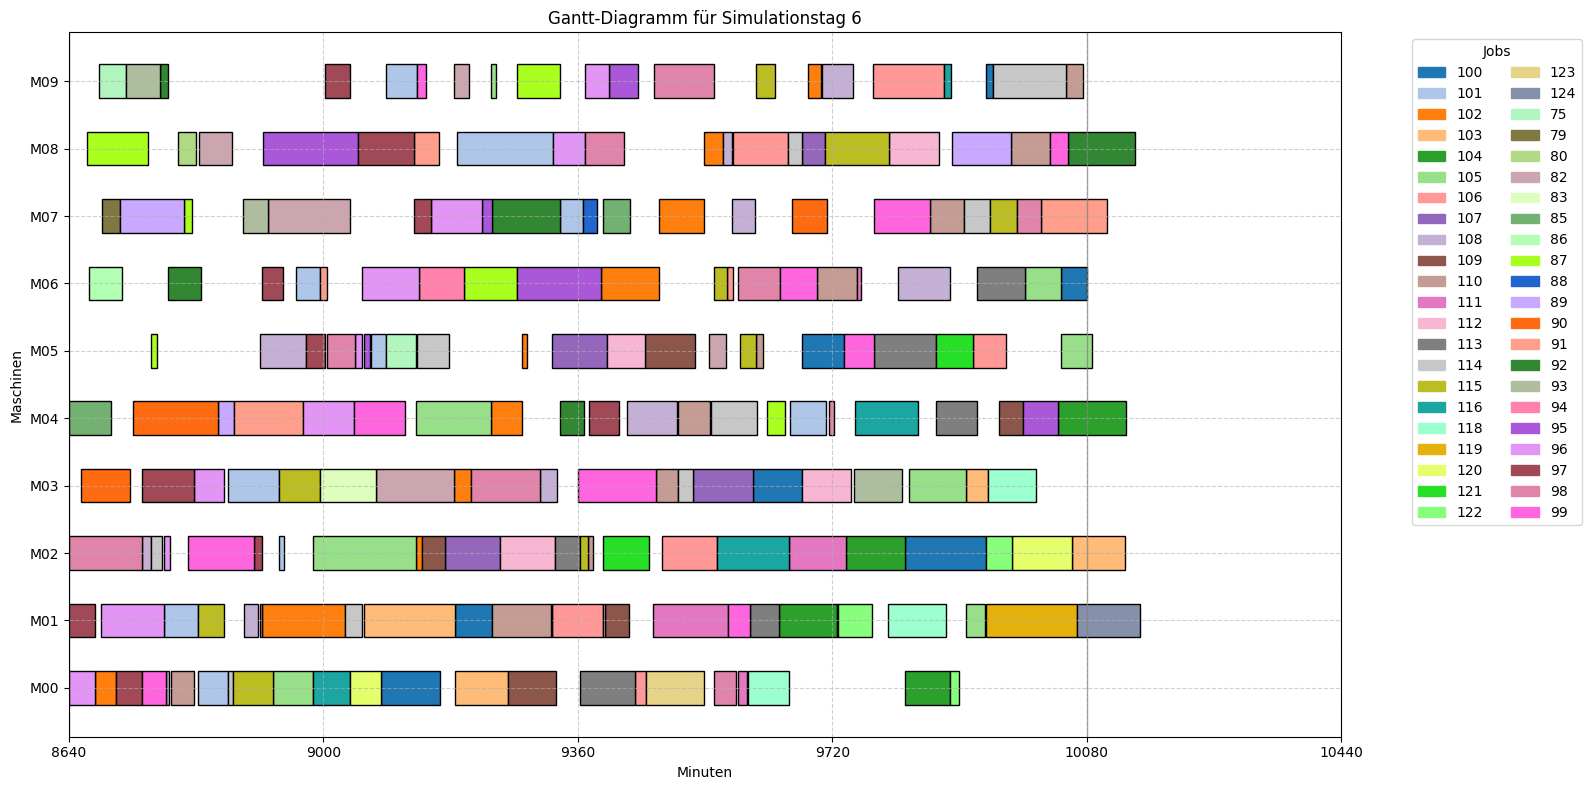

----------------------------------------------------------------------
Day 07: [10080, 11520)
[INFO] Anzahl Jobs mit Ready Time 10080: 22
[INFO] 122 zusätzliche Operationen hinzugefügt (gesamt: 342).
[INFO] 6 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.


In [ ]:
for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length*day_numb 
    day_end = day_start + day_length
    print(f"Day {day_numb:02d}: [{day_start}, {day_end})")

    # ------------------------ I. Operationsvorbereitung ------------------------
    #----------------------------------------------------------------------------
    
    # ---------- a) Filterung nach der aktuellen "Ready Time" ----------
    df_jssp_curr, df_job_times_curr = process_filter.jobs_by_ready_time(df_job_times_all, df_jssp_all, ready_time = day_start, verbose=True)

    
    # ---------- b) Zusammenführung mit unerledigten Operationen -------
    df_jssp_curr = process_filter.extend_with_undone_operations(df_jssp_curr, df_undone, verbose=True)
    df_times_curr = process_filter.update_times_after_operation_changes(df_job_times_all, df_jssp_curr)

    # ------------------- II. Relevante laufende Operationen -------------------------
    df_execution_important = process_filter.get_operations_running_into_day(df_execution, day_start, verbose=True)

    # ------------------------ III. Rescheduling --------------------------------
    #----------------------------------------------------------------------------

    df_schedule = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_fixed_ops(df_jssp_curr, df_times_curr, 
                                                                                          df_execution_important, w_t = 5,
                                                                                          reschedule_start = day_start, 
                                                                                          msg=False, timeLimit=max_time, gapRel= 0.002)
    
    file = file_template.format(text= f"schedule_{day_numb:02d}")
    df_schedule.to_csv(data_path / file, index=False)
    
    show.plot_gantt(df_schedule, perspective="Machine", title=f"Gantt-Diagramm für Schedule ab Tag {day_numb}")
    check.all_in_one(df_schedule)

    last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 240, steps= 60))

    # ------------------------ IV. Simulation -----------------------------------
    simulation = ProductionDaySimulation(df_schedule, vc=0.25)
    df_execution = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}")
    else:
        print(f"Nothing executed on day {day_numb}")

    df_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
    print("-"*70)